In [1]:
from __future__ import annotations
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import helpers

warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.display.float_format = "{:,.3f}".format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

In [2]:
# load to dataframe
INFILE = '/home/grace/work/SEER/data/SEER_2010_2020_RICH.clean.tsv'
maintable = helpers.load_seer_data(INFILE)


Basic filtering
- Beginning: 4669817 patients, 5014112 records.
- Removed 205661 patients, 235781 records where 'cancer_group' in ['Brain', 'Miscellaneous'].
- Removed 105196 patients, 113837 records where 'hist_group' in ['unspecified neoplasms'].
- Removed 0 patients, 0 records where 'diagnosis_year' not in range [2010, 2020].
- Removed 284312 patients, 589846 records with duplicated patient_id.
- Removed 0 patients, 0 records where primary cancer is marked as metastasis
- Final: 4074648 patients, 4074648 records.


### MAIN STATISTICS PLOT (cancer group)

In [ ]:
# calc stats
PREDICTOR = 'cancer_group_CAT'
RESPONSE = 'brain_met_BOOL'
# table = helpers.subset_cancer_groups(maintable, min_cases_brainmet=100)
valid_cancer = helpers.select_categorical_feature_values(maintable, predictor=PREDICTOR, response=RESPONSE, min_cases_total=10000, min_cases_response=200, top=15)
table = maintable[maintable[PREDICTOR].isin(valid_cancer)].copy()
ptable = helpers.prevalence(table, PREDICTOR, RESPONSE)
ttable = helpers.prevalence(table[table['any_met_BOOL']==True], PREDICTOR, RESPONSE)
sframe = ptable.copy()
sframe = sframe.rename(columns={'stat': 'prevalence'})
sframe['tendency'] = ttable['stat'] / 100
sframe


                              total  brain_met_BOOL  valid
Lung and Bronchus            359792           39866   True
Skin                         363252            2693   True
Breast                       738895            2522   True
Kidney and Renal Pelvis      134787            2133   True
Colorectal                   315145             913   True
Esophagus                     36580             676   True
Pancreas                     106778             418   True
Stomach                       61766             398   True
Prostate                     503390             375   True
Non-Hodgkin Lymphoma         163242             359   True
Uterus                       130920             317   True
Testis                        25974             230   True
Liver                         71411             209   True
Soft Tissue including Heart   29285             196  False
Urinary Bladder              147551             185  False
Other Digestive Organs         6168             183  Fa

,False,True,records,prevalence
cancer_group_CAT,,,,
Breast,727230,2522,729752,0.346
Colorectal,304682,913,305595,0.299
Esophagus,33949,676,34625,1.952
Kidney and Renal Pelvis,129475,2133,131608,1.621
Liver,64871,209,65080,0.321
Lung and Bronchus,304002,39866,343868,11.593
Non-Hodgkin Lymphoma,60428,359,60787,0.591
Pancreas,101169,418,101587,0.411
Prostate,476653,375,477028,0.079


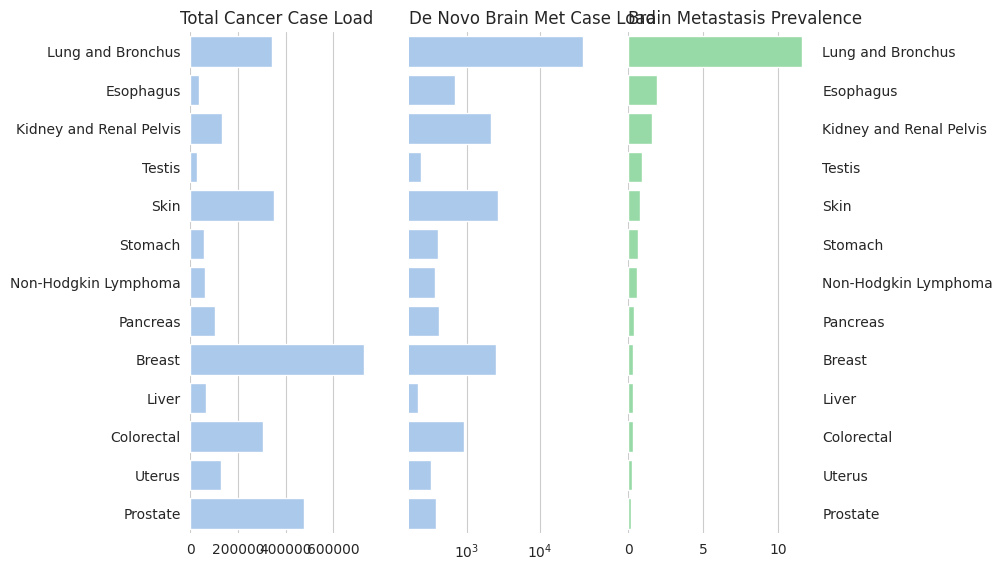

In [ ]:
# plot
stat_frame = sframe.sort_values('prevalence', ascending=False)
stat_frame['prevalence'] = stat_frame['prevalence'].clip(lower=0.2)
sns.set_color_codes("pastel")
sns.set_style("whitegrid")

FIG_X = 8
FIG_Y = stat_frame.shape[0] / 2
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(FIG_X, FIG_Y), width_ratios=[1, 1, 0.3], sharey=False, dpi=100)
case_ax = axes[0]
prev_ax = axes[1]
pref_ax = axes[2]

### Cases Subplot ###
sns.barplot(data=stat_frame, x="records", y=PREDICTOR, color="b", ax=case_ax)

### Prevalence Subplot ###
sns.barplot(data=stat_frame, x="prevalence", y=PREDICTOR, color="g", legend=False, ax=prev_ax)

### Tendency Subplot ###
sns.heatmap(data=stat_frame['tendency'].to_frame(), annot=True, fmt=".2f", cmap='PuRd', square=True, linewidth=.5, center=0.2, cbar=False, ax=pref_ax)

### Aesthetics ###
case_ax.set_title('Total Cancer Case Load', loc='right')
prev_ax.set_title('Brain Metastasis Prevalence', loc='left')
pref_ax.set_title('Brain Preference', loc='left')

# remove axis labels & spines from all subplots 
for ax in axes.flat:
    ax.set_ylabel('')
    ax.set_xlabel('')
    sns.despine(left=True, bottom=True, top=True, right=True, ax=ax)

# y axis ticks / labels 
# case_ax.set_yticklabels([])
case_ax.tick_params(axis='y', pad=-5)
prev_ax.set_yticklabels([])
pref_ax.yaxis.tick_right()
pref_ax.tick_params(axis='y', right=False, rotation=0, pad=5)

# x axis ticks / labels 
# left
xticks = [x * 100_000 for x in range(1, 8, 2)]
xlabels = [f"{x//1000}k" for x in xticks]
case_ax.set_xticks(xticks, xlabels)
# middle
xticks = [2, 4, 6, 8, 10]
xlabels = [f"{x}%" for x in xticks]
prev_ax.set_xticks(xticks, xlabels)
# right
pref_ax.set_xticks([])

# invert left axes
case_ax.invert_xaxis()

# move right axes closer 
box = pref_ax.get_position()
box.x0 = box.x0 - 0.03
box.x1 = box.x1 - 0.03
pref_ax.set_position(box)

# show
outfile = '/home/grace/work/SEER/outputs/figure1/figure.png'
# plt.tight_layout()
plt.savefig(outfile)
plt.show()
plt.close()

### PREVALENCE VS PREFERENCE SCATTERPLOT (cancer_group:hist_group)

In [5]:
# subset
PREDICTOR = 'cancer_group_CAT:hist_group_CAT'
RESPONSE = 'brain_met_BOOL'
ctable = maintable[maintable['cancer_group_CAT'].isin(valid_cancer)].copy()
ctable[PREDICTOR] = ctable['cancer_group_CAT'] + ':' + ctable['hist_group_CAT']
valid_cancer_histology = helpers.select_categorical_feature_values(ctable, predictor=PREDICTOR, response=RESPONSE, min_cases_response=50)
chtable = ctable[ctable[PREDICTOR].isin(valid_cancer_histology)].copy()



                                                          total  brain_met_BOOL  valid
Lung and Bronchus:adenomas and adenocarcinomas           164571           21153   True
Lung and Bronchus:epithelial neoplasms                    98954           14258   True
Lung and Bronchus:squamous cell neoplasms                 81549            3883   True
Skin:nevi and melanomas                                  347139            2668   True
Kidney and Renal Pelvis:adenomas and adenocarcinomas     121403            1987   True
Breast:ductal and lobular neoplasms                      686880            1984   True
Colorectal:adenomas and adenocarcinomas                  284157             803   True
Esophagus:adenomas and adenocarcinomas                    22237             547   True
Lung and Bronchus:cystic, mucinous and serous neoplasms    4703             319   True
Pancreas:adenomas and adenocarcinomas                     81203             314   True
Prostate:adenomas and adenocarcinomas     

In [210]:
# calc stats
amet_df = helpers.prevalence(chtable, PREDICTOR, 'any_met_BOOL')
bmet_df = helpers.prevalence(chtable[chtable['any_met_BOOL']==True], PREDICTOR, RESPONSE)
sframe = amet_df.copy()
sframe['p(amet)'] = sframe['stat'] / 100
sframe['p(bmet)|amet'] = bmet_df['stat'] / 100
sframe = sframe.drop(['stat'], axis=1)
sframe = sframe.reset_index()
sframe['cancer_group'] = sframe[PREDICTOR].apply(lambda x: x.split(':')[0])
sframe['hist_group'] = sframe[PREDICTOR].apply(lambda x: x.split(':')[1])
sframe = sframe.set_index(PREDICTOR)
sframe = sframe.sort_values(['cancer_group', 'hist_group'])
sframe


,False,True,records,p(amet),p(bmet)|amet,cancer_group,hist_group
cancer_group_CAT:hist_group_CAT,,,,,,,
Breast:adenomas and adenocarcinomas,23398,2077,25475,0.082,0.120,Breast,adenomas and adenocarcinomas
Breast:ductal and lobular neoplasms,660906,25974,686880,0.038,0.079,Breast,ductal and lobular neoplasms
Breast:epithelial neoplasms,8023,2451,10474,0.234,0.120,Breast,epithelial neoplasms
Colorectal:adenomas and adenocarcinomas,232737,51420,284157,0.181,0.016,Colorectal,adenomas and adenocarcinomas
Colorectal:epithelial neoplasms,4683,2534,7217,0.351,0.026,Colorectal,epithelial neoplasms
Esophagus:adenomas and adenocarcinomas,15508,6729,22237,0.303,0.083,Esophagus,adenomas and adenocarcinomas
Esophagus:squamous cell neoplasms,8946,2201,11147,0.197,0.041,Esophagus,squamous cell neoplasms
Kidney and Renal Pelvis:adenomas and adenocarcinomas,105455,15948,121403,0.131,0.128,Kidney and Renal Pelvis,adenomas and adenocarcinomas
Kidney and Renal Pelvis:epithelial neoplasms,680,729,1409,0.517,0.114,Kidney and Renal Pelvis,epithelial neoplasms


In [260]:
df = sframe.copy()

# only keep cancer groups which have 2+ hist groups.
counts = df['cancer_group'].value_counts()
valid = counts[counts>1].index.to_list()
df = df[df['cancer_group'].isin(valid)]

# only keep hist groups which have 2+ cancer groups.
counts = df['hist_group'].value_counts()
valid = counts[counts>1].index.to_list()
df = df[df['hist_group'].isin(valid)]
print(df.head())


                                          False   True  records  p(amet)  p(bmet)|amet cancer_group                    hist_group
cancer_group_CAT:hist_group_CAT                                                                                                  
Breast:adenomas and adenocarcinomas       23398   2077    25475    0.082         0.120       Breast  adenomas and adenocarcinomas
Breast:epithelial neoplasms                8023   2451    10474    0.234         0.120       Breast          epithelial neoplasms
Colorectal:adenomas and adenocarcinomas  232737  51420   284157    0.181         0.016   Colorectal  adenomas and adenocarcinomas
Colorectal:epithelial neoplasms            4683   2534     7217    0.351         0.026   Colorectal          epithelial neoplasms
Esophagus:adenomas and adenocarcinomas    15508   6729    22237    0.303         0.083    Esophagus  adenomas and adenocarcinomas


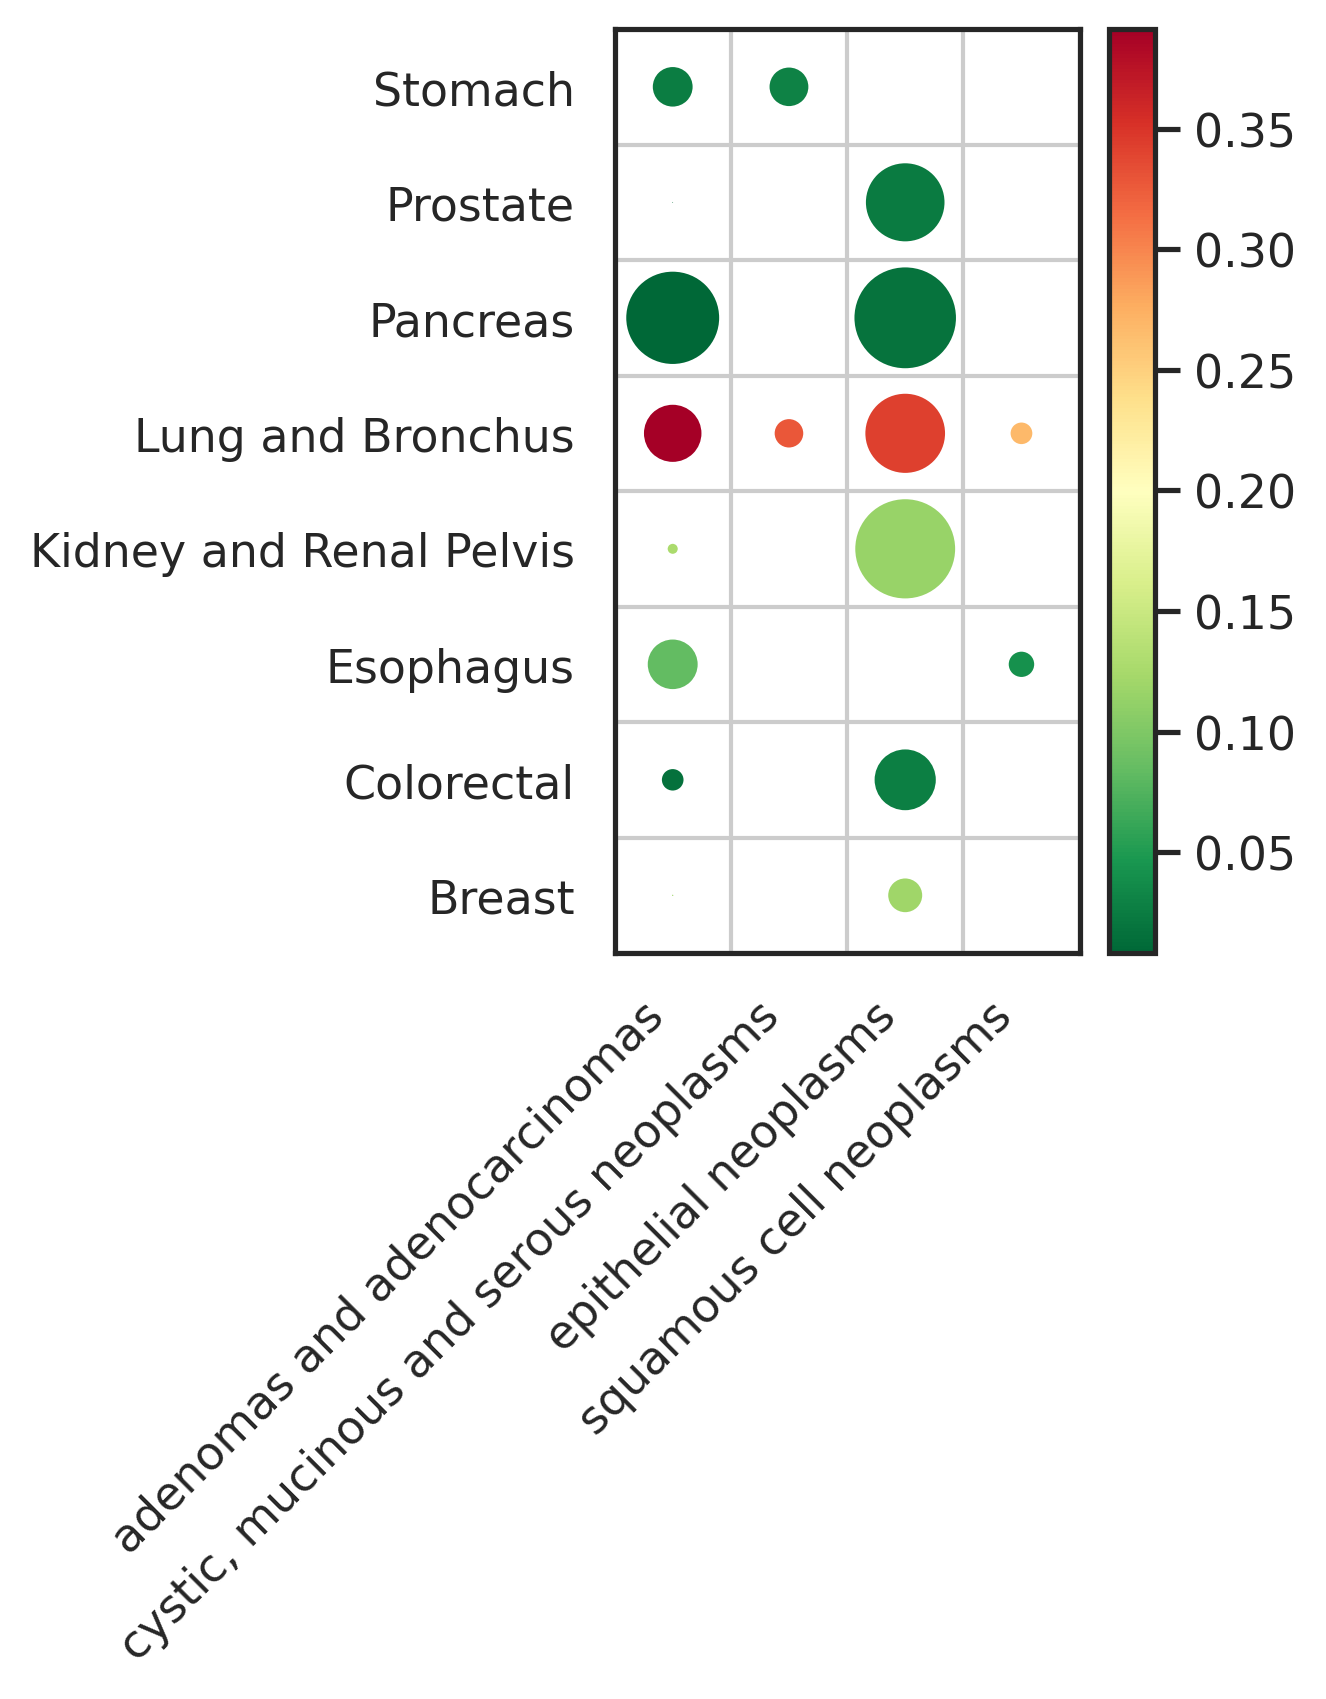

In [267]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
sns.set_style('white')

xlabels = sorted(list(df['hist_group'].unique()))
ylabels = sorted(list(df['cancer_group'].unique()))
nX = len(xlabels)
nY = len(ylabels)

x, y = np.meshgrid(np.arange(nX), np.arange(nY))
s = df.pivot(index='cancer_group', columns='hist_group', values='p(amet)').to_numpy()
c = df.pivot(index='cancer_group', columns='hist_group', values='p(bmet)|amet').to_numpy()
r = s.copy()

scale = 0.5
fig, ax = plt.subplots(figsize=((nX+1)*scale, nY*scale), dpi=300)

circles = [plt.Circle((j,i), radius=r-0.07, edgecolor=None, linewidth=0) for r, j, i in zip(s.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=c.flatten(), cmap="autumn_r")
col = PatchCollection(circles, array=c.flatten(), cmap="RdYlGn_r")
ax.add_collection(col)

ax.set(xticks=np.arange(nX), yticks=np.arange(nY),
       xticklabels=xlabels, yticklabels=ylabels)
ax.set_xticks(np.arange(nX+1)-0.5, minor=True)
ax.set_yticks(np.arange(nY+1)-0.5, minor=True)
ax.grid(which='minor')

fig.colorbar(col)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.savefig('/home/grace/work/SEER/outputs/figure1/heatmap_bubble.png')
plt.show()

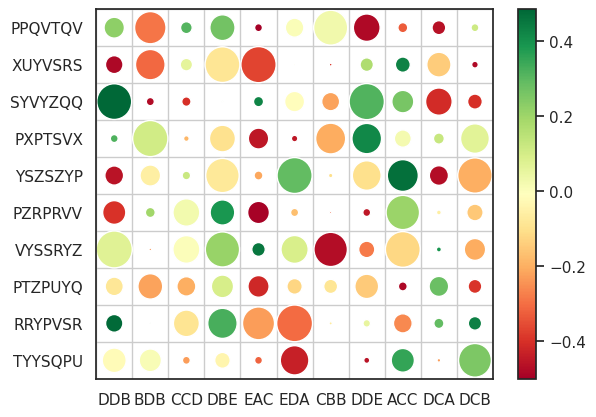

In [222]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection

N = 10
M = 11
ylabels = ["".join(np.random.choice(list("PQRSTUVXYZ"), size=7)) for _ in range(N)]
xlabels = ["".join(np.random.choice(list("ABCDE"), size=3)) for _ in range(M)]

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = np.random.randint(0, 180, size=(N,M))
c = np.random.rand(N, M)-0.5

fig, ax = plt.subplots()

R = s/s.max()/2
circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=c.flatten(), cmap="RdYlGn")
ax.add_collection(col)

ax.set(xticks=np.arange(M), yticks=np.arange(N),
       xticklabels=xlabels, yticklabels=ylabels)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.grid(which='minor')

fig.colorbar(col)
plt.show()

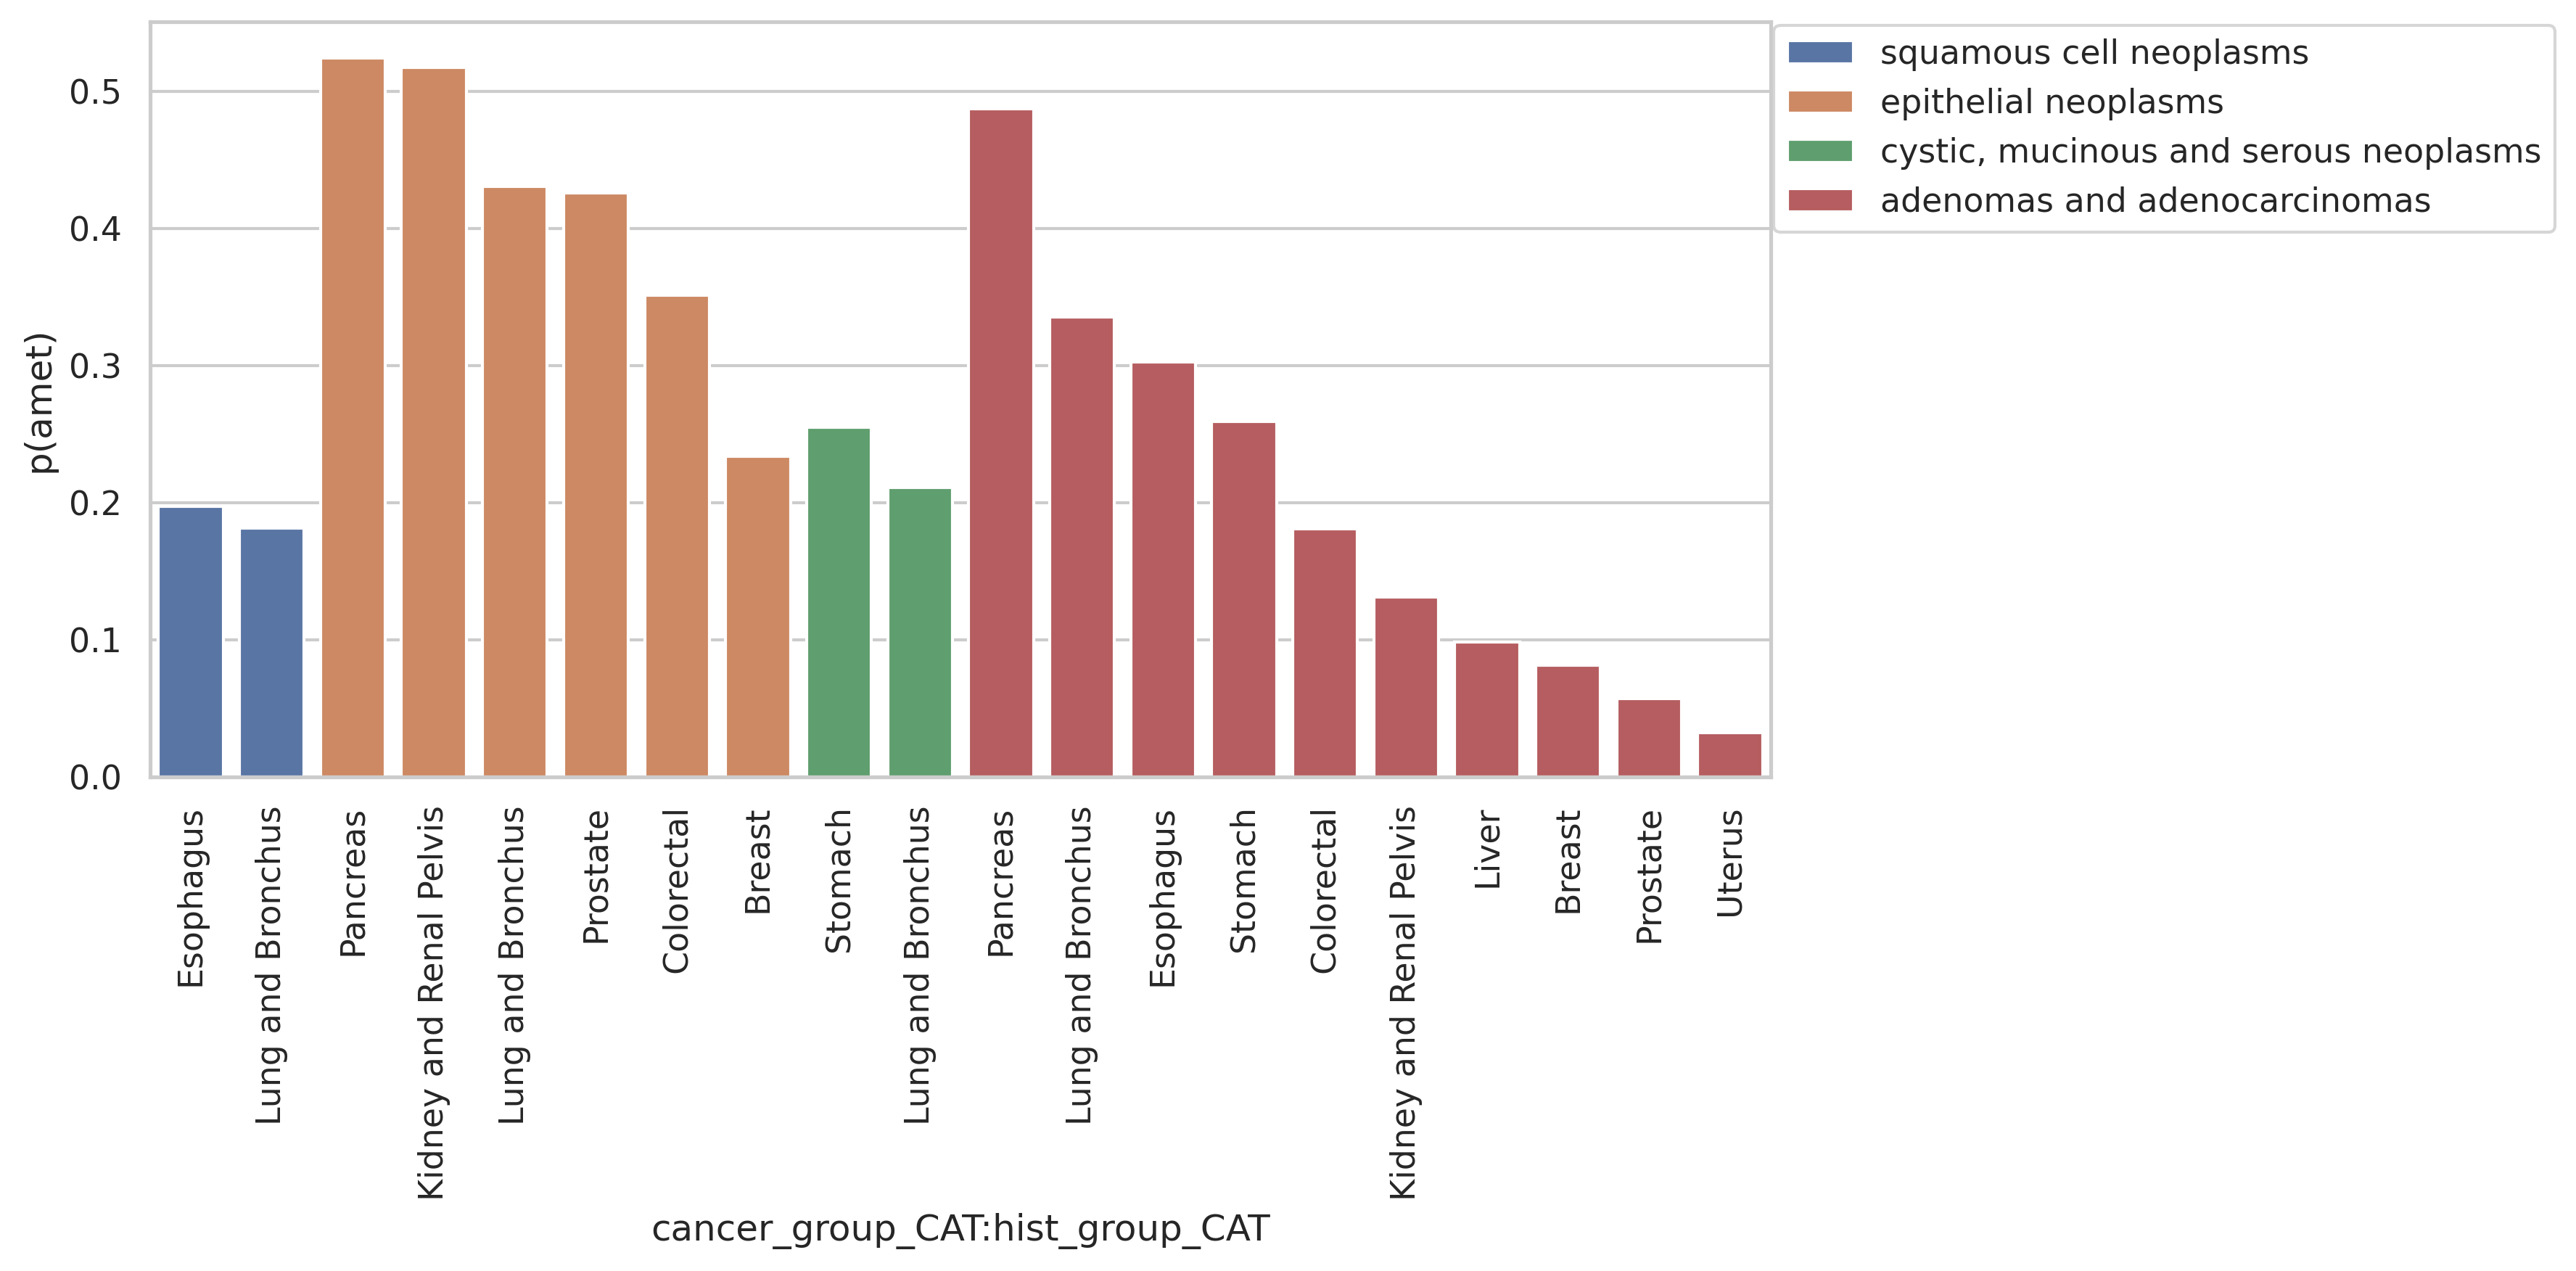

In [208]:
# sns.catplot(
#     df, kind="bar",
#     x="hist_group", y="p(amet)", col="cancer_group", hue='hist_group',
#     height=4, aspect=.5,
# )

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
df = df.sort_values(['hist_group', 'p(amet)'], ascending=False)
sns.barplot(df.reset_index(), x=PREDICTOR, y="p(amet)", hue="hist_group", ax=ax)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.1, fontsize=11)

# labels = ax.get_xticklabels()
xlabels = [label._text.split(':')[0] for label in ax.get_xticklabels()]
ax.set_xticklabels(xlabels, rotation=90)
outfile = '/home/grace/work/SEER/outputs/figure1/barplot_histology_metrate.png'
plt.tight_layout()
plt.savefig(outfile)
print()

                                          False   True  records  p(amet)  p(bmet)|amet cancer_group                    hist_group
cancer_group_CAT:hist_group_CAT                                                                                                  
Breast:adenomas and adenocarcinomas       23398   2077    25475    0.082         0.120       Breast  adenomas and adenocarcinomas
Breast:epithelial neoplasms                8023   2451    10474    0.234         0.120       Breast          epithelial neoplasms
Colorectal:adenomas and adenocarcinomas  232737  51420   284157    0.181         0.016   Colorectal  adenomas and adenocarcinomas
Colorectal:epithelial neoplasms            4683   2534     7217    0.351         0.026   Colorectal          epithelial neoplasms
Esophagus:adenomas and adenocarcinomas    15508   6729    22237    0.303         0.083    Esophagus  adenomas and adenocarcinomas


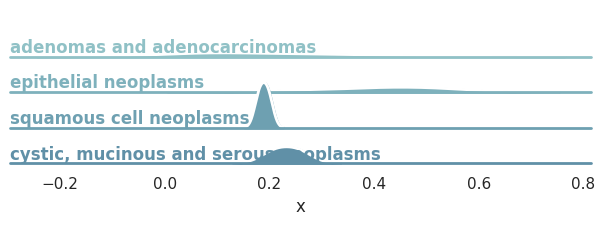

In [176]:
df = sframe.copy()

# only keep cancer groups which have 2+ hist groups.
counts = df['hist_group'].value_counts()
valid = counts[counts>1].index.to_list()
df = df[df['hist_group'].isin(valid)]
print(df.head())

df['x'] = df['p(amet)']
df['g'] = df['hist_group']
df = df[['x', 'g'].copy()]

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# # Create the data
# rs = np.random.RandomState(1979)
# x = rs.randn(500)
# g = np.tile(list("ABCDEFGHIJ"), 50)
# df = pd.DataFrame(dict(x=x, g=g))
# m = df.g.map(ord)
# df["x"] += m
# print(df.head())

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=1)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)


Text(1, 0.5, 'Colorectal (Epithelial)')
Text(1, 1.5, 'Prostate (Epithelial)')
Text(1, 2.5, 'Kidney and Renal Pelvis (Epithelial)')
Text(1, 3.5, 'Pancreas (Adenocarcinoma)')
Text(1, 4.5, 'Pancreas (Epithelial)')
Text(1, 5.5, 'Testis (Trophoblastic)')
Text(1, 6.5, 'Lung and Bronchus (Adenocarcinoma)')
Text(1, 7.5, 'Lung and Bronchus (Epithelial)')
Text(1, 8.5, 'Lung and Bronchus (Acinar Cell)')
Text(1, 9.5, 'Lung and Bronchus (Cystic/Mucinous/Serous)')
Text(1, 10.5, 'Lung and Bronchus (Squamous Cell)')
Text(1, 11.5, 'Breast (Epithelial)')
Text(1, 12.5, 'Esophagus (Adenocarcinoma)')
Text(1, 13.5, 'Stomach (Adenocarcinoma)')
Text(1, 14.5, 'Stomach (Cystic/Mucinous/Serous)')
Text(1, 15.5, 'Kidney and Renal Pelvis (Transitional Cell)')
Text(1, 16.5, 'Colorectal (Adenocarcinoma)')
Text(1, 17.5, 'Esophagus (Squamous Cell)')
Text(1, 18.5, 'Breast (Adenocarcinoma)')
Text(1, 19.5, 'Kidney and Renal Pelvis (Adenocarcinoma)')
Text(1, 20.5, 'Prostate (Adenocarcinoma)')
Text(1, 21.5, 'Breast (Ductal/

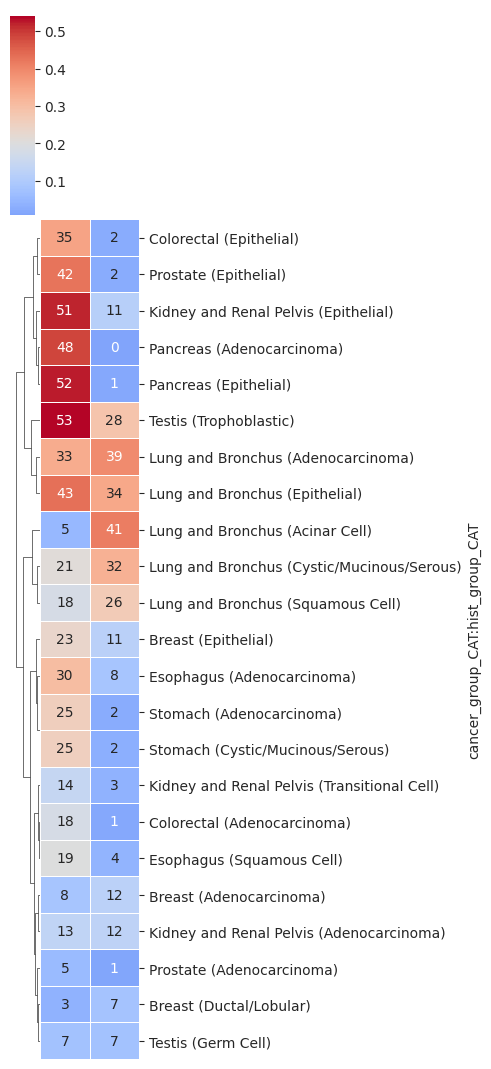

In [158]:
# fig, ax = plt.subplots(figsize=(12, 8))
# sns.heatmap(data=sframe, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidth=.5, center=0.2, cbar=False, ax=ax)
import matplotlib
import matplotlib.colors as mcolors

df = sframe.copy()

# only keep cancer groups which have 2+ hist groups.
counts = df['cancer_group'].value_counts()
valid = counts[counts>1].index.to_list()
df = df[df['cancer_group'].isin(valid)]

# format hist groups
def format_hist_group(text: str) -> str:
    lut = {
        'adenomas and adenocarcinomas': 'Adenocarcinoma',
        'ductal and lobular neoplasms': 'Ductal/Lobular',
        'epithelial neoplasms': 'Epithelial',
        'squamous cell neoplasms': 'Squamous Cell',
        'transitional cell papillomas and carcinomas': 'Transitional Cell',
        'acinar cell neoplasms': 'Acinar Cell',
        'cystic, mucinous and serous neoplasms': 'Cystic/Mucinous/Serous',
        'germ cell neoplasms': 'Germ Cell',
        'trophoblastic neoplasms': 'Trophoblastic',
    }
    return lut[text]

df['hist_group'] = df['hist_group'].apply(format_hist_group)
df = df.reset_index()
df[PREDICTOR] = df['cancer_group'] + ' (' + df['hist_group'] + ')'
df = df.set_index(PREDICTOR)

# df = df.loc[[
# 'Breast:adenomas and adenocarcinomas',
# 'Breast:ductal and lobular neoplasms',
# 'Breast:epithelial neoplasms',
# 'Colorectal:adenomas and adenocarcinomas',
# 'Colorectal:epithelial neoplasms',
# 'Esophagus:adenomas and adenocarcinomas',
# 'Esophagus:squamous cell neoplasms',
# 'Kidney and Renal Pelvis:adenomas and adenocarcinomas',
# 'Kidney and Renal Pelvis:epithelial neoplasms',
# 'Kidney and Renal Pelvis:transitional cell papillomas and carcinomas',
# 'Liver:adenomas and adenocarcinomas',
# 'Lung and Bronchus:acinar cell neoplasms',
# 'Lung and Bronchus:adenomas and adenocarcinomas',
# 'Lung and Bronchus:cystic, mucinous and serous neoplasms',
# 'Lung and Bronchus:epithelial neoplasms',
# 'Lung and Bronchus:squamous cell neoplasms',
# 'Non-Hodgkin Lymphoma:nhl - mature b-cell lymphomas',
# 'Pancreas:adenomas and adenocarcinomas',
# 'Pancreas:epithelial neoplasms',
# 'Prostate:adenomas and adenocarcinomas',
# 'Prostate:epithelial neoplasms',
# 'Skin:nevi and melanomas',
# 'Stomach:adenomas and adenocarcinomas',
# 'Stomach:cystic, mucinous and serous neoplasms',
# 'Testis:germ cell neoplasms',
# 'Testis:trophoblastic neoplasms',
# 'Uterus:adenomas and adenocarcinomas',
# ]]
# df = df.sort_values(['cancer_group', 'hist_group'])

# cell annotations
df['p(amet)_annot'] = df['p(amet)'].apply(lambda x: int(x*100))
df['p(bmet)|amet_annot'] = df['p(bmet)|amet'].apply(lambda x: int(x*100))

# cancer margin color 
cancer_palette = [
    '#1f77b4',
    '#ff7f0e',
    '#2ca02c',
    '#d62728',
    '#9467bd',
    '#8c564b',
    '#e377c2',
    '#7f7f7f',
    '#bcbd22',
    '#17becf',
    '#0afae2',
    '#05fc47',
    '#fccb08',
]
cancer_color_lut = {g: c for g, c in zip(list(df['cancer_group'].unique()), cancer_palette)}
df['cancer_color'] = df['cancer_group'].map(cancer_color_lut)

# histology margin color 
cmap = matplotlib.colormaps['Set3']
hist_color_lut = {h: mcolors.to_hex(cmap(i), keep_alpha=False) for i, h in enumerate(list(df['hist_group'].unique()))}
df['hist_color'] = df['hist_group'].map(hist_color_lut)

df_data = df[['p(amet)', 'p(bmet)|amet']]
df_annot = df[['p(amet)_annot', 'p(bmet)|amet_annot']]
df_colmargin = df[['cancer_color', 'hist_color']]

FACTOR = 0.48
FIG_Y = df.shape[0] * FACTOR
FIG_X = 2 * FACTOR + 4
cm = sns.clustermap(
    data=df_data,
    annot=df_annot,
    # row_colors=df_colmargin, colors_ratio=0.1,
    linewidth=.5,  # fmt=".2f",
    cmap='coolwarm', center=.20, row_cluster=True, col_cluster=False, 
    method='complete', 
    # metric='cityblock',
    figsize=(FIG_X, FIG_Y)
)

for label in cm.ax_heatmap.get_yticklabels():
    print(label)

# cm.ax_heatmap.set_yticks([])
cm.ax_heatmap.set_xticks([])

plt.savefig('/home/grace/work/SEER/outputs/figure1/figure_sub7.png', dpi=300)
plt.show()
plt.close()



[]

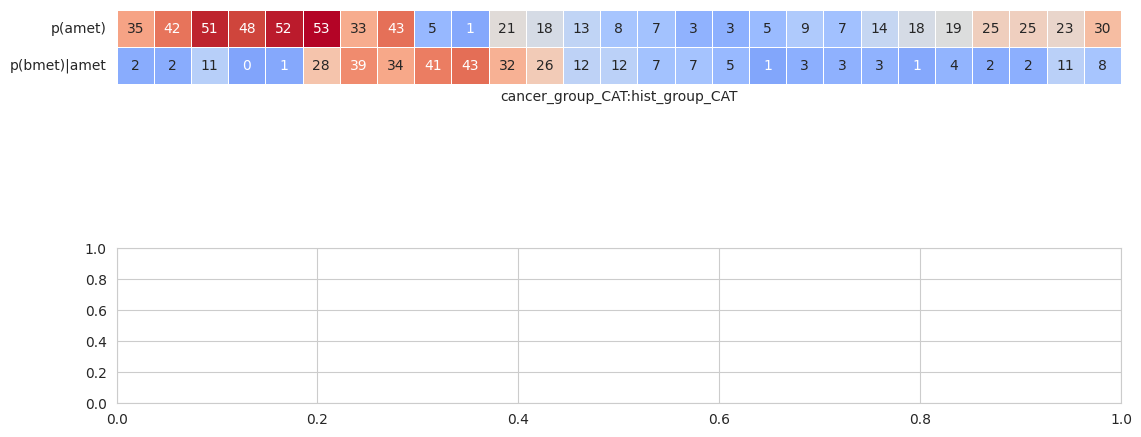

In [75]:
FACTOR = 0.48
FIG_X = df.shape[0] * FACTOR
FIG_Y = 3 * FACTOR + 5.2
cframe_data = cm.data2d
cframe_annot = cm.data2d.copy()

for col in cframe_annot.columns:
    cframe_annot[col] = cframe_annot[col].apply(lambda x: int(x*100))

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(FIG_X, FIG_Y), height_ratios=(2, 1))
sns.heatmap(data=cframe_data, annot=cframe_annot, cmap='coolwarm', square=True, linewidth=.5, center=.2, cbar=False, ax=axes[0])
axes[0].set_xticks([])

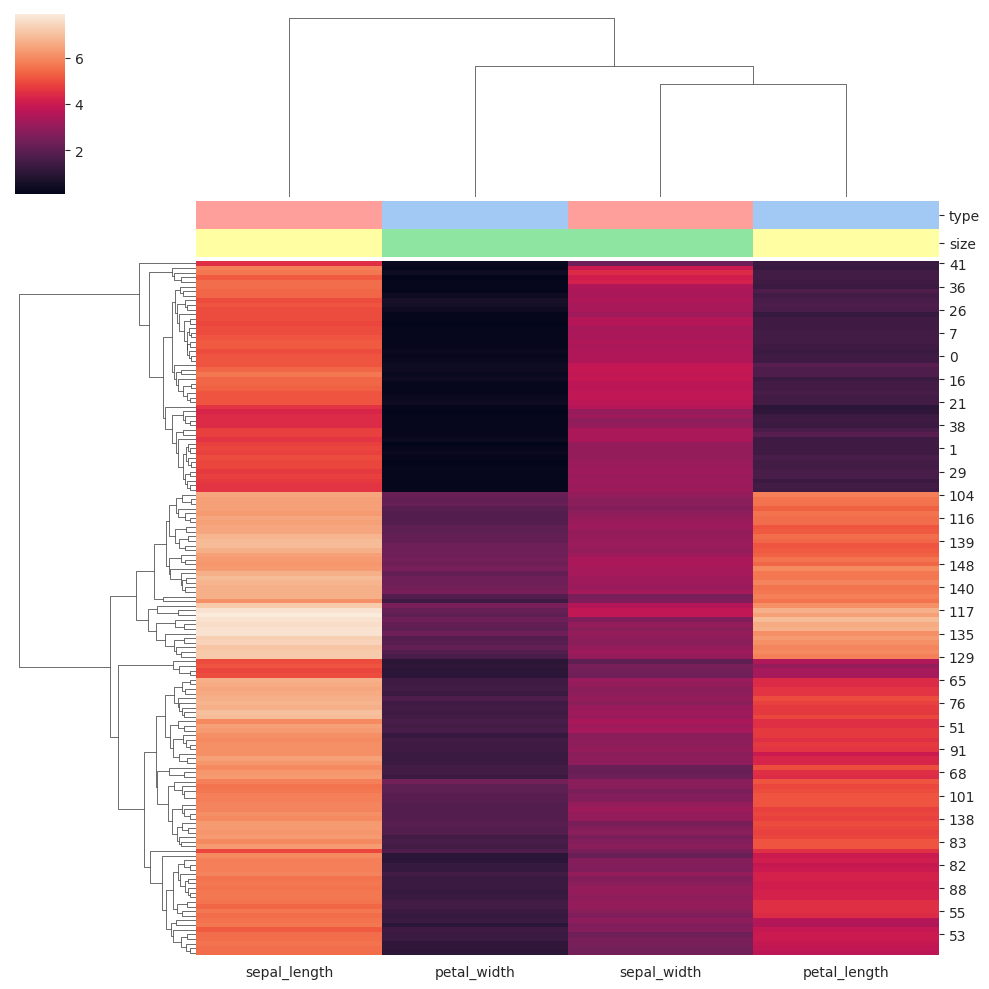

In [78]:
import seaborn as sns
import pandas as pd

data = sns.load_dataset("iris")
data.pop("species")

color_pal = ["r", "r", "b", "b"]
color_th = ["y", "g", "y", "g"]
color_df = pd.DataFrame({"type": color_pal, "size": color_th}, index=data.columns)

sns.clustermap(data=data, col_colors=color_df)

In [160]:
sframe.head()

,False,True,records,p(amet),p(bmet)|amet,cancer_group,hist_group
cancer_group_CAT:hist_group_CAT,,,,,,,
Breast:adenomas and adenocarcinomas,23398,2077,25475,0.082,0.120,Breast,adenomas and adenocarcinomas
Breast:ductal and lobular neoplasms,660906,25974,686880,0.038,0.079,Breast,ductal and lobular neoplasms
Breast:epithelial neoplasms,8023,2451,10474,0.234,0.120,Breast,epithelial neoplasms
Colorectal:adenomas and adenocarcinomas,232737,51420,284157,0.181,0.016,Colorectal,adenomas and adenocarcinomas
Colorectal:epithelial neoplasms,4683,2534,7217,0.351,0.026,Colorectal,epithelial neoplasms


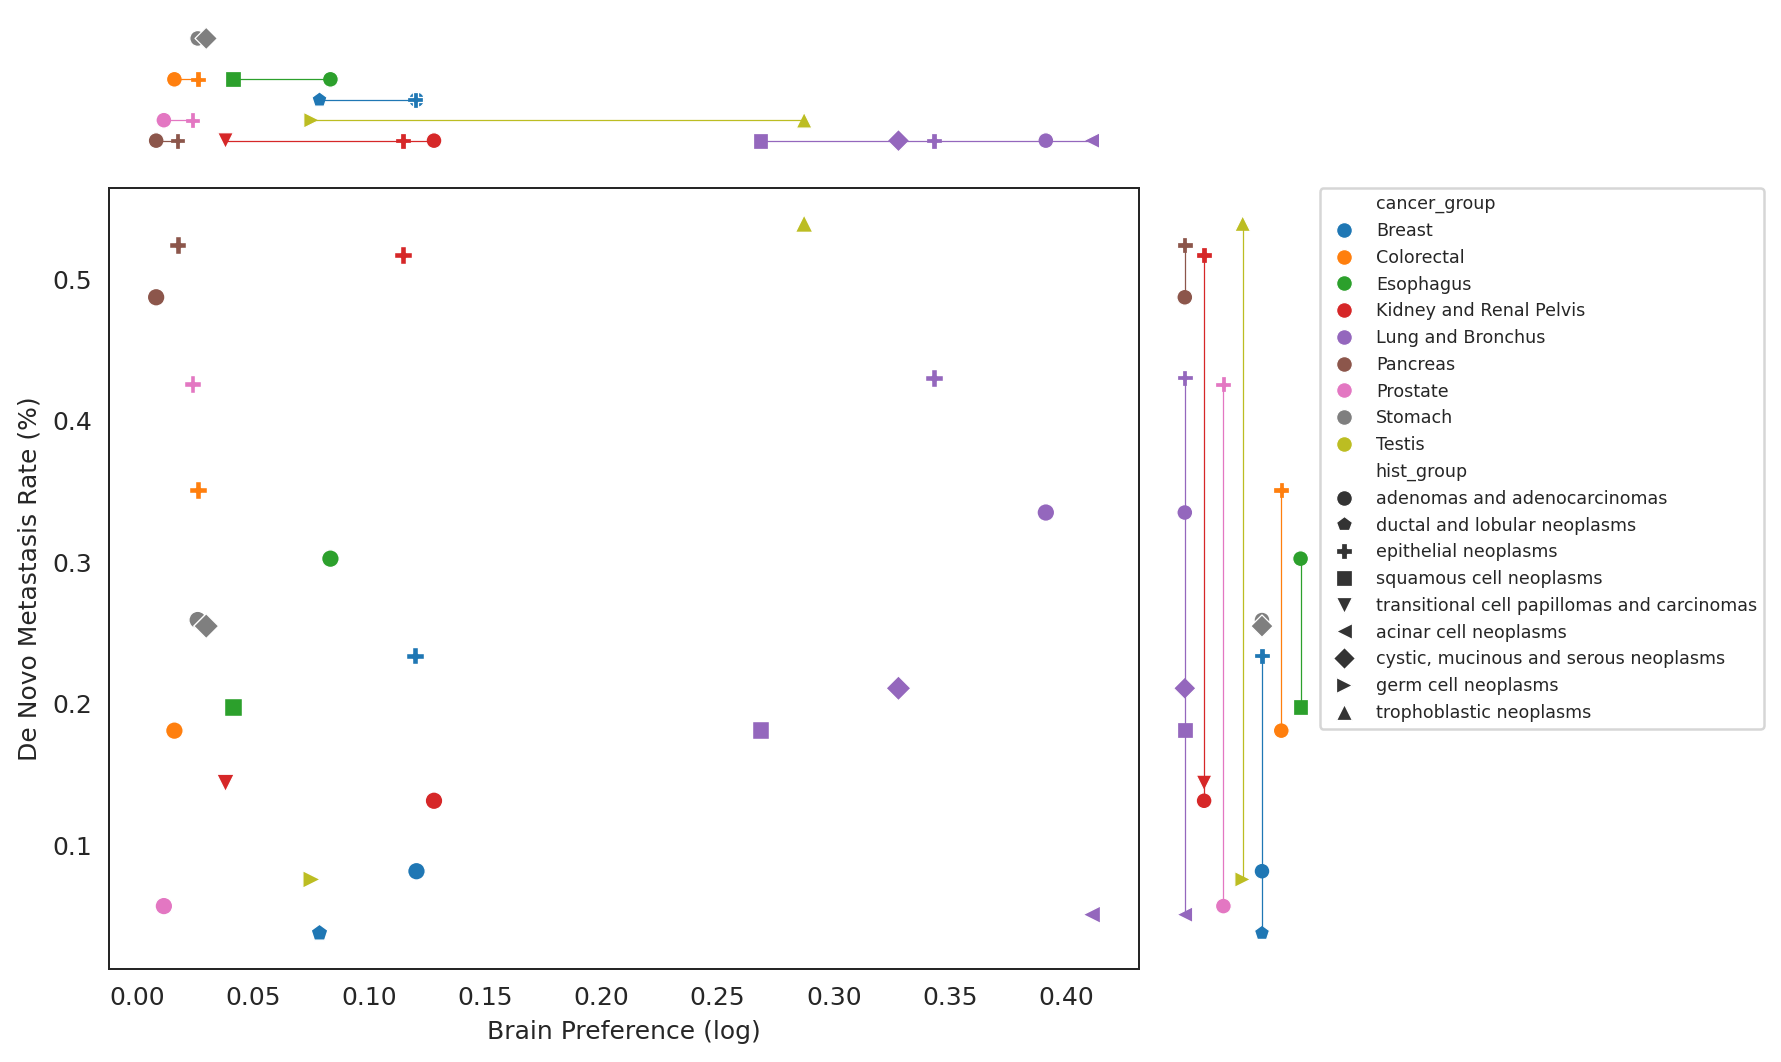

In [169]:
import matplotlib
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
sns.set_style('white')

# cmap = matplotlib.colormaps['tab10']
# for i in range(10):
#     print(mcolors.to_hex(cmap(i), keep_alpha=False))

# for c in sframe['cancer_group'].unique():
#     print(c)

df = sframe.copy()
df = df.rename(columns={'p(amet)': 'prevalence', 'p(bmet)|amet': 'tendency'})

# only keep cancer groups which have 2+ hist groups.
counts = df['cancer_group'].value_counts()
valid = counts[counts>1].index.to_list()
df = df[df['cancer_group'].isin(valid)]

# markers
hgroups = list(df['hist_group'].unique())
markers = ['o', 'p', 'P', 's', 'v', '<', 'D', '>', '^', 'X', 'H']
marker_lut = {hgroup: marker for hgroup, marker in zip(hgroups, markers)}
df['marker'] = df['hist_group'].map(marker_lut)

# colors
cancer_palette = [
    '#1f77b4',
    '#ff7f0e',
    '#2ca02c',
    '#d62728',
    '#9467bd',
    '#8c564b',
    '#e377c2',
    '#7f7f7f',
    '#bcbd22',
    '#17becf',
    '#0afae2',
    '#05fc47',
    '#fccb08',
]
cmap = matplotlib.colormaps['viridis']
cgroups = list(df['cancer_group'].unique())
color_lut = {g: c for g, c in zip(cgroups, cancer_palette)}
df['color'] = df['cancer_group'].map(color_lut)

# render
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), width_ratios=(6, 0.9), height_ratios=(1.1, 6), dpi=180)
col_ax = axes[0][0]
blank_ax = axes[0][1]
main_ax = axes[1][0]
row_ax = axes[1][1]

# render main plot
# sns.scatterplot(data=df, x='tendency', y='prevalence', hue='cancer_group', palette=color_lut, style='hist_group', markers=marker_lut, s=80, ax=main_ax)
sns.scatterplot(data=df, x='tendency', y='prevalence', hue='cancer_group', palette=color_lut, style='hist_group', markers=marker_lut, s=50, ax=main_ax, legend=False)

# render col margin
col_idx_lut = {
    'Pancreas': 0,
    'Kidney and Renal Pelvis': 0,
    'Lung and Bronchus': 0,
    'Skin': 0,
    'Prostate': 1,
    'Uterus': 1,
    'Testis': 1,
    'Breast': 2,
    'Liver': 2,
    'Colorectal': 3,
    'Esophagus': 3,
    'Non-Hodgkin Lymphoma': 4,
    'Stomach': 5,
}
df['col_y_loc'] = df['cancer_group'].map(col_idx_lut)
for cgroup, tendency_l in df.groupby('cancer_group')['tendency'].agg(list).to_dict().items():
    x0 = min(tendency_l)
    x1 = max(tendency_l)
    # if abs(x1-x0) > 0.01:
    col_ax.hlines(y=col_idx_lut[cgroup], xmin=x0, xmax=x1, linewidth=0.5, color=color_lut[cgroup], linestyles='-')
sns.scatterplot(data=df, x='tendency', y='col_y_loc', hue='cancer_group', palette=color_lut, style='hist_group', markers=marker_lut, s=40, ax=col_ax, legend=False)
col_ax.set_ylim(-1, 6)
# col_ax.set_xlim(main_ax.get_xlim())

# render row margin
row_idx_lut = {
    'Pancreas': 0,
    'Lung and Bronchus': 0,
    'Skin': 0,
    'Uterus': 0,
    'Kidney and Renal Pelvis': 1,
    'Prostate': 2,
    'Testis': 3,
    'Breast': 4,
    'Stomach': 4,
    'Liver': 5,
    'Colorectal': 5,
    'Non-Hodgkin Lymphoma': 5,
    'Esophagus': 6,
}
df['row_x_loc'] = df['cancer_group'].map(row_idx_lut)
for cgroup, prevalence_l in df.groupby('cancer_group')['prevalence'].agg(list).to_dict().items():
    y0 = min(prevalence_l)
    y1 = max(prevalence_l)
    if abs(y1-y0) > 0.02:
        row_ax.vlines(x=row_idx_lut[cgroup], ymin=y0, ymax=y1, linewidth=0.5, color=color_lut[cgroup], linestyles='-')
sns.scatterplot(data=df, x='row_x_loc', y='prevalence', hue='cancer_group', palette=color_lut, style='hist_group', markers=marker_lut, s=40, ax=row_ax, legend=True)
row_ax.set_xlim(-1, 7)

# # legend (seaborn auto)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0., fontsize=7)

main_ax.set_ylabel('De Novo Metastasis Rate (%)')
main_ax.set_xlabel('Brain Preference (log)')

for ax in [col_ax, blank_ax, row_ax]:
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticks([])
    ax.set_xticks([])
    sns.despine(left=True, bottom=True, top=True, right=True, ax=ax)

plt.tight_layout()
plt.show()
# ax.legend(handles=legend_elements)



<br><br><br><br><br><br><br><br><br><br><br><br>

In [ ]:


gs = fig.add_gridspec(1, 3)

### Cases Subplot ###
ax1 = fig.add_subplot(gs[0])
sns.barplot(data=stat_frame, x="records", y=PREDICTOR, color="b", ax=ax1)

### Prevalence Subplot ###
ax2 = fig.add_subplot(gs[1], sharey=ax1)
sns.barplot(data=stat_frame, x="prevalence", y=PREDICTOR, color="g", ax=ax2, legend=False)

### Tendency Subplot ###
ax3 = fig.add_subplot(gs[2], sharey=ax1)
sns.heatmap(data=stat_frame['tendency'].to_frame(), cmap='coolwarm', ax=ax3, center=0.2)

### Aesthetics ###
ax1.set_title('Total Cancer Case Load')
ax2.set_title('Brain Met Prevalence')
ax3.set_title('Brain Met Preference')

# ax1
xticks = [200, 400, 1_000, 2_000, 4_000, 10_000, 20_000, 40_000]
xlabels = [f"{x//1000}k" if x >= 1000 else str(x) for x in xticks]
ax1.set_xscale('log')
ax1.set_xlim(0, 80_000)
ax1.axvline(1_000, color='black', lw=1)
ax1.axvline(10_000, color='black', lw=1)
ax1.set_xticks(xticks, xlabels)
ax1.invert_xaxis()

# ax2
# xticks2 = [2, 4, 6, 8, 10]
xticks2 = [0.25, 0.5, 1, 2, 4, 8]
xlabels2 = [f"{x}%" for x in xticks2]
ax2.set_xscale('log')
ax2.set_xticks(xticks2, xlabels2)
plt.setp(ax2.get_yticklabels(), visible=False)

# ax3
# xticks3 = [1, 2, 4, 8, 16, 32, 64]
# xlabels3 = [f"{x}x" for x in xticks3]
# ax3.set_xticks(xticks3, xlabels3)
# ax3.yaxis.tick_right()

# all axes
for ax in [ax1, ax2, ax3]:
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    # sns.despine(left=True, bottom=True, ax=ax)

# moving odds plot
# box = ax3.get_position()
# box.x0 = box.x0 - 0.02
# box.x1 = box.x1 - 0.02
# ax3.set_position(box)

plt.show()
plt.close()

In [9]:
ttable

,False,True,records,stat
cancer_group_CAT,,,,
Breast,27332,2522,29854,8.448
Colorectal,55261,913,56174,1.625
Esophagus,8894,676,9570,7.064
Kidney and Renal Pelvis,16015,2133,18148,11.753
Lung and Bronchus,71825,39866,111691,35.693
Pancreas,46241,418,46659,0.896
Skin,3790,2693,6483,41.539


PREVALENCE

In [ ]:
### PREVALENCE ###
# calculate prevalences per cancer_group.
# brain case load, plus brain/bone/lung/liver met rates

# from util_funcs import calculate_logodds
from util_funcs import calculate_prevalence
from util_funcs import calculate_relrisk
from util_funcs import select_valid

# FEATURE = 'cancer_group:hist_group'
# maintable[FEATURE] = maintable['cancer_group'] + ':' + maintable['hist_group']
FEATURE = 'cancer_group'
MIN_RECORDS = 5000
SEC_FEATURES = {'brain_met'}
SEC_MINCOUNT = 100
VALID_FEATURES = select_valid(maintable, feature=FEATURE, min_records=MIN_RECORDS, sec_features=SEC_FEATURES, sec_mincount=SEC_MINCOUNT)

# otable = calculate_logodds(feature=FEATURE, valid=VALID_FEATURES, response='brain_met', table=maintable)
ptable = calculate_prevalence(FEATURE, VALID_FEATURES, 'brain_met', maintable)
rtable = calculate_relrisk(FEATURE, VALID_FEATURES, 'brain_met', maintable)
mtable = calculate_relrisk(FEATURE, VALID_FEATURES, 'brain_met', maintable[maintable['any_met']=='YES'])


In [ ]:
assert set(ptable.index) == set(rtable.index)
assert set(rtable.index) == set(mtable.index)
stat_frame = ptable.copy()
stat_frame['relRisk'] = mtable['relRisk']
stat_frame['relRiskLow'] = mtable['relRiskLow']
stat_frame['relRiskHigh'] = mtable['relRiskHigh']
stat_frame = stat_frame.sort_values('YES', ascending=False).head(20)
stat_frame = stat_frame.reset_index()
print(stat_frame)

In [ ]:
import matplotlib as mpl
cmap = mpl.colormaps['tab20']

def assign_load_cat(load: int) -> str:
    if load >= 10_000:
        return 'high'
    elif load >= 1_000:
        return 'moderate'
    else:
        return 'low'

def assign_prevalence_cat(prev: float) -> str:
    if prev >= 10:
        return 'high'
    elif prev >= 1:
        return 'moderate'
    else:
        return 'low'

def assign_tendency_cat(pref: float) -> str:
    if pref >= 20:
        return 'high'
    elif pref >= 5:
        return 'moderate'
    else:
        return 'low'


palette = {feat: cmap(i) for i, feat in enumerate(sorted(list(stat_frame[FEATURE].unique())))}

stat_frame['load_group'] = stat_frame['YES'].apply(assign_load_cat)
stat_frame['prevalence_group'] = stat_frame['prevalence (%)'].apply(assign_prevalence_cat)
stat_frame['tendency_group'] = stat_frame['relRisk'].apply(assign_tendency_cat)

strats = ['load_group', 'prevalence_group', 'tendency_group']
values = ['YES', 'prevalence (%)', 'relRisk']
colors = ['b', 'g', 'r']
sns.set_color_codes("pastel")
for strat, value, color in zip(strats, values, colors):
    print(strat)
    fig, axes = plt.subplots(
        nrows=1, ncols=3, figsize=(8, 3), sharey=False, 
        width_ratios=[
            stat_frame[stat_frame[strat]=='high'].shape[0],
            stat_frame[stat_frame[strat]=='moderate'].shape[0],
            stat_frame[stat_frame[strat]=='low'].shape[0],
        ]
    )

    stat_frame = stat_frame.sort_values(value, ascending=False)
    for ax, group in zip(axes, ['high', 'moderate', 'low']):
        df = stat_frame[stat_frame[strat]==group]
        # sns.barplot(data=df, x=FEATURE, y=value, color=color, hue=FEATURE, palette=palette, ax=ax)
        # sns.barplot(data=df, x=FEATURE, y=value, color=color, hue=FEATURE, ax=ax)
        sns.barplot(data=df, x=FEATURE, y=value, color=color, ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.set_title(group)

    # plt.tight_layout()
    plt.title(group)
    plt.subplots_adjust(wspace=0.4)
    plt.show()
    plt.close()

In [ ]:

# Initialize the matplotlib figure
# sns.set_theme(style="whitegrid")
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 16), width_ratios=[3, 2, 3], sharey=True)
# ax1 = axes[0]
# ax2 = axes[1]
# ax3 = axes[2]

stat_frame = stat_frame.sort_values('YES', ascending=False)
sns.set_color_codes("pastel")

fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(1, 3)

### Cases Subplot ###
with sns.axes_style("whitegrid"):
    ax1 = fig.add_subplot(gs[0])
    # sns.barplot(data=stat_frame, x="records", y=FEATURE, color="b", ax=ax1)
    sns.barplot(data=stat_frame, x="YES", y=FEATURE, color="b", ax=ax1)

### Prevalence Subplot ###
with sns.axes_style("whitegrid"):
    ax2 = fig.add_subplot(gs[1], sharey=ax1)
    sns.barplot(data=stat_frame, x="prevalence (%)", y=FEATURE, color="g", ax=ax2, legend=False)

### Odds Ratio Subplot ###
with sns.axes_style("whitegrid"):
    ax3 = fig.add_subplot(gs[2], sharey=ax1)

    def plot_ci(y: int, low: float, high: float, ax) -> None:
        height = 0.2
        color = 'grey'
        cap_top = y + height / 2
        cap_bot = y - height / 2
        ax.plot([low, high], [y, y], color=color)
        ax.plot([low, low], [cap_bot, cap_top], color=color)
        ax.plot([high, high], [cap_bot, cap_top], color=color)

    for i, row in stat_frame.iterrows():
        plot_ci(y=i, low=row['relRiskLow'], high=row['relRiskHigh'], ax=ax3)
    
    sns.pointplot(
        data=stat_frame, x="relRisk", y=FEATURE,  errorbar=None, 
        linestyle="none", marker="o", ax=ax3, legend=False, capsize=.4,
        color='r', markersize=2, 
    )

ax3.axvline(1, c='b', ls='--')
ax3.set_xscale('log')

### Aesthetics ###
ax1.set_title('Total Records')
ax2.set_title('Brain Met Prevalence')
ax3.set_title('Brain Met Relative Risk | Metastasis')

# ax1
# xticks1 = [300_000, 600_000, 900_000, 1_200_000, 1_500_000]
# xlabels1 = [f"{x//1000}k" if x <1_000_000 else f"{x/1_000_000:.1f}m" for x in xticks1]
# xticks1 = [250, 500, 1_000, 2_000, 4_000, 8_000, 16_000, 32_000]
xticks1 = [200, 400, 1_000, 2_000, 4_000, 10_000, 20_000, 40_000]
xlabels1 = [f"{x//1000}k" if x >= 1000 else str(x) for x in xticks1]
ax1.set_xscale('log')
ax1.set_xlim(0, 80_000)
ax1.axvline(1_000, color='black', lw=1)
ax1.axvline(10_000, color='black', lw=1)
ax1.set_xticks(xticks1, xlabels1)
ax1.invert_xaxis()

# ax2
# xticks2 = [2, 4, 6, 8, 10]
xticks2 = [0.25, 0.5, 1, 2, 4, 8]
xlabels2 = [f"{x}%" for x in xticks2]
ax2.set_xscale('log')
ax2.set_xticks(xticks2, xlabels2)
plt.setp(ax2.get_yticklabels(), visible=False)
# ax2.set_xlim(0, xticks2[-1]+0.1)
# ax2.set_xlim(0, 6)
# ax2.set_yticks([], [])

# ax3
xticks3 = [1, 2, 4, 8, 16, 32, 64]
xlabels3 = [f"{x}x" for x in xticks3]
ax3.set_xticks(xticks3, xlabels3)
ax3.yaxis.tick_right()
# plt.setp(ax3.get_yticklabels(), )
# ax2.set_yticks([], [])

# all axes
for ax in [ax1, ax2, ax3]:
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    # sns.despine(left=True, bottom=True, ax=ax)

# moving odds plot
# box = ax3.get_position()
# box.x0 = box.x0 - 0.02
# box.x1 = box.x1 - 0.02
# ax3.set_position(box)

plt.show()
plt.close()